In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

image_shape = (150, 200, 3)


2025-03-15 12:22:48.620522: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 12:22:48.699381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 12:22:48.699426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 12:22:48.700872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 12:22:48.711680: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [2]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed"


In [3]:
dataset_dir_list = [
    os.path.join(dataset_dir, folder)
    for folder in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, folder))
]

csv_path_list = [os.path.join(dir, "_labels.csv") for dir in dataset_dir_list]

csv_df = None

for csv_path in csv_path_list:
    df = pd.read_csv(csv_path, index_col="image_id")
    if "_red" in csv_path or "_obj" in csv_path:
        continue
    # undersampling
    elif "oval" in csv_path:
        df = df.sample(frac=1.0, random_state=42)
    # oversampling
    elif "T_" in csv_path:
        df = df.sample(frac=1, replace=True, random_state=42)
    df.index = csv_path.split("/")[-2] + "/" + df.index
    csv_df = pd.concat([csv_df, df])

csv_df = csv_df[["angle", "left_arrow", "right_arrow"]]

2025-03-15 12:22:55.973351: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-15 12:22:56.069096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-15 12:22:56.069176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-15 12:22:56.082290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-15 12:22:56.082652: I external/local_xla/xla/stream_executor

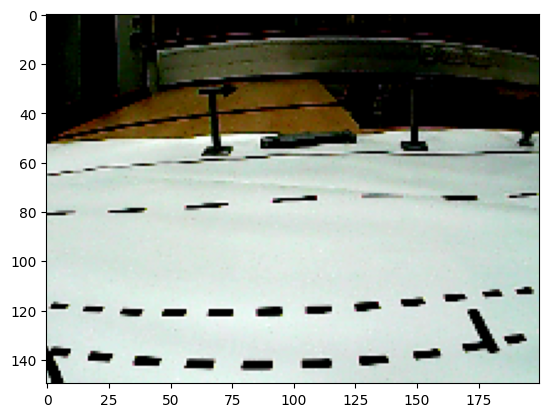

In [4]:
def process_image(img, enhance=True):
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img * 2 - 1.0
    img = tf.image.resize(img, [image_shape[0], image_shape[1]])
    return img

rand_image = csv_df.sample(1)
rand_image_path = os.path.join(dataset_dir, rand_image.index[0] + ".png")
img = process_image(tf.io.read_file(rand_image_path))

plt.imshow(img)

In [5]:
base_model = keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)

intermediate_layer_model = Model(
            inputs=base_model.input,
            outputs=base_model.layers[-1].output
        )

model = intermediate_layer_model
# model = base_model
model.output.shape

TensorShape([None, 5, 7, 576])

In [ ]:
# tf.keras.utils.plot_model(
#     base_model,
#     show_shapes=True,  # Show input/output shapes
#     show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
#     expand_nested=False,  # Keep it flat (no base_model nesting)
#     show_layer_activations=True,
#     dpi=96,  # Image resolution
# )
# print("Saved model image: model.png")

Saved model image: model.png


1/1 [==============================] - 0s 17ms/step


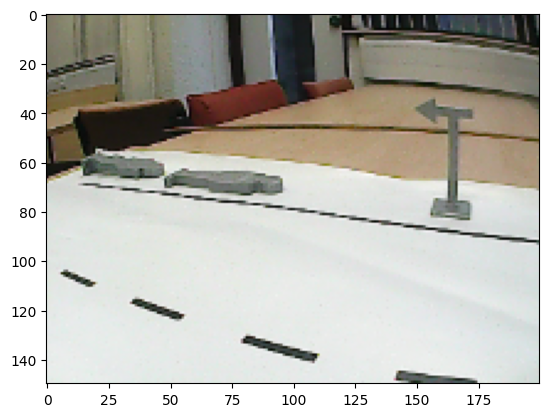

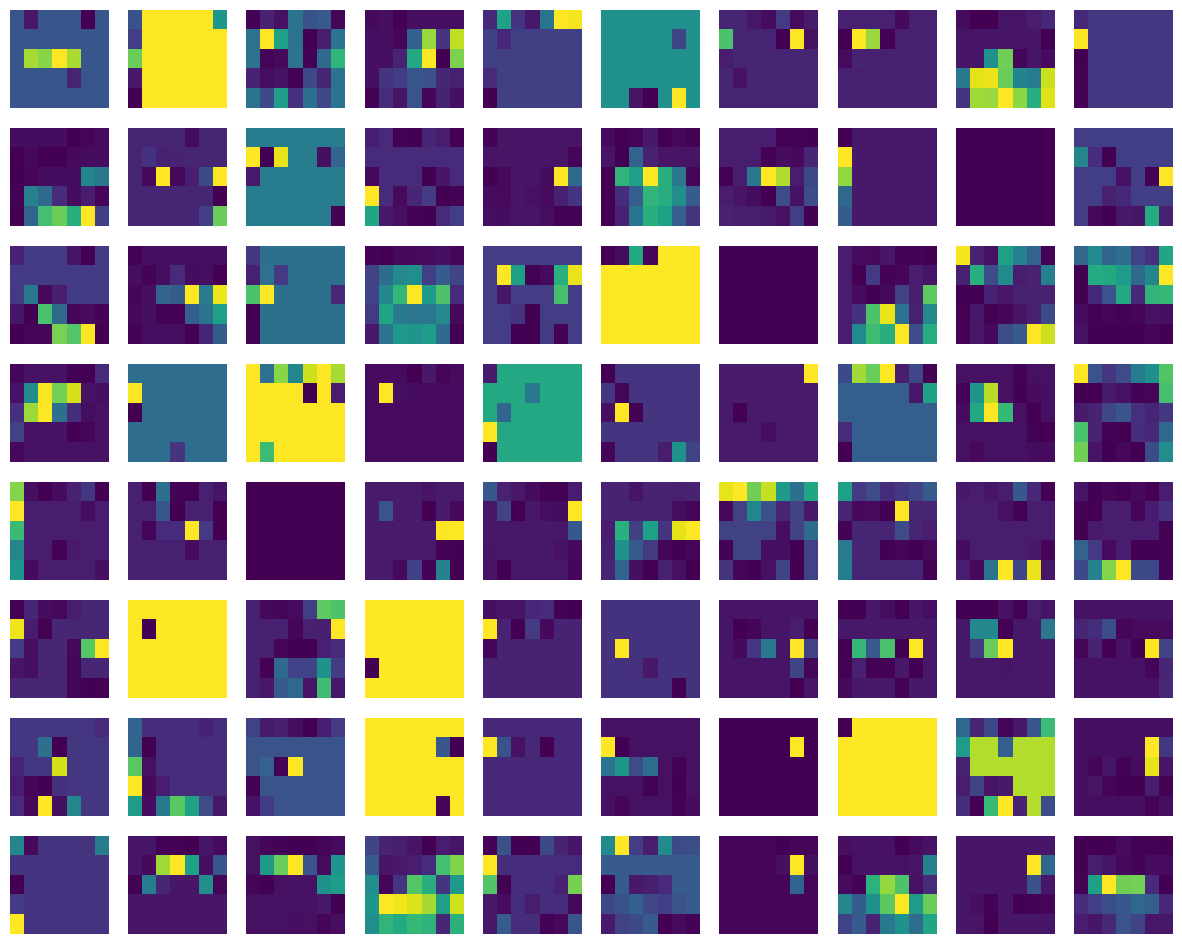

In [10]:
rand_image = csv_df.sample(1)
rand_image_path = os.path.join(dataset_dir, rand_image.index[0] + ".png")
img = process_image(tf.io.read_file(rand_image_path))
img = tf.expand_dims(img, axis=0)

pred_raw = model.predict(img)
plt.imshow((process_image(tf.io.read_file(rand_image_path)) + 1)/2)

fig, ax = plt.subplots(8, 10, figsize=(15, 15*0.8))
ax = ax.ravel()

pred = pred_raw[0]

channel_variances = np.var(pred_raw[0, :, :, :], axis=(0, 1))
top_channels = np.argsort(channel_variances)[-80:]

# for i in range(50):
for i in range(80):
    # channel = pred[:, :, top_channels[i]]
    channel = pred[:, :, i]
    ax[i].imshow(channel)
    ax[i].axis("off")
    ax[i].axis("tight")  # gets rid of white border

1311
1/1 [==============================] - 1s 525ms/step


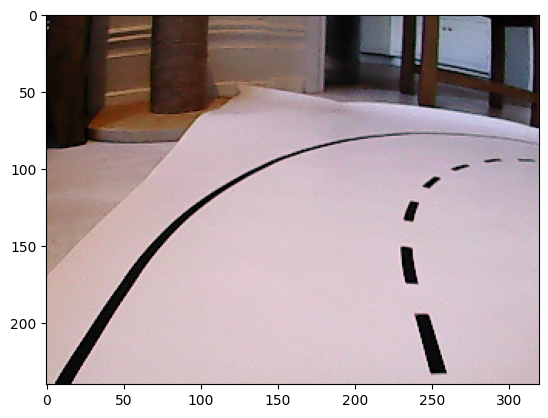

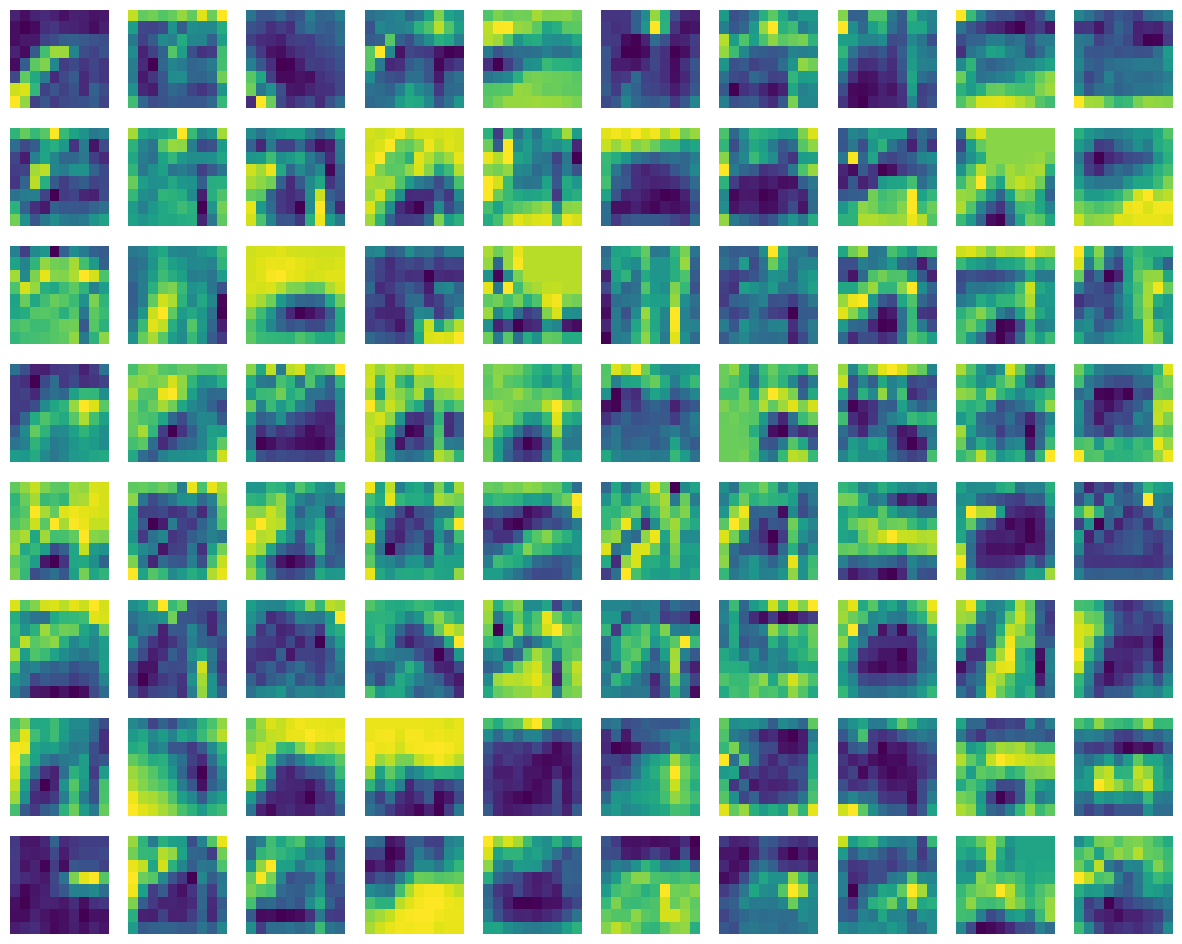

In [145]:
train_dir = os.path.join(dataset_dir, "training_data/training_data")

rand_id = np.random.randint(1, 13798)

print(rand_id)

image_path = os.path.join(train_dir, f"{rand_id}.png")

img = tf.io.read_file(image_path)

img = tf.io.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)

plt.imshow(img)

img = img * 2 - 1.0

img = tf.expand_dims(img, axis=0)

pred_raw = model.predict(img)


fig, ax = plt.subplots(8, 10, figsize=(15, 15*0.8))
ax = ax.ravel()

pred = pred_raw[0]

channel_variances = np.var(pred_raw[0, :, :, :], axis=(0, 1))
top_channels = np.argsort(channel_variances)[-80:]

# for i in range(50):
for i in range(80):
    # channel = pred[:, :, top_channels[i]]
    channel = pred[:, :, i]
    ax[i].imshow(channel)
    ax[i].axis("off")
    ax[i].axis("tight")  # gets rid of white border

#   print(max(channel.ravel()))